In [21]:
import importlib, subprocess, sys
if importlib.util.find_spec("sklearn") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

plt.rcParams["figure.figsize"] = (10, 6)

df = pd.read_csv("../Dataset/neo_clean.csv", low_memory=False)


In [12]:
# missing percentage per column
missing_pct = df.isna().mean().sort_values(ascending=False)
missing_summary = pd.DataFrame({
    "missing_pct": missing_pct,
    "n_missing": (missing_pct * len(df)).astype(int),
    "dtype": df.dtypes[missing_pct.index].astype(str)
})
display(missing_summary.head(40))
print(f"\nTotal rows: {len(df)}")


,missing_pct,n_missing,dtype
GM,0.999874,39704,float64
G,0.999647,39695,float64
spec_T,0.999093,39673,object
two_body,0.996726,39579,object
spec_B,0.992118,39396,object
n_del_obs_used,0.972324,38610,float64
n_dop_obs_used,0.972324,38610,float64
albedo,0.969679,38505,float64
diameter,0.968571,38461,float64
rot_per,0.945075,37528,float64



Total rows: 39709


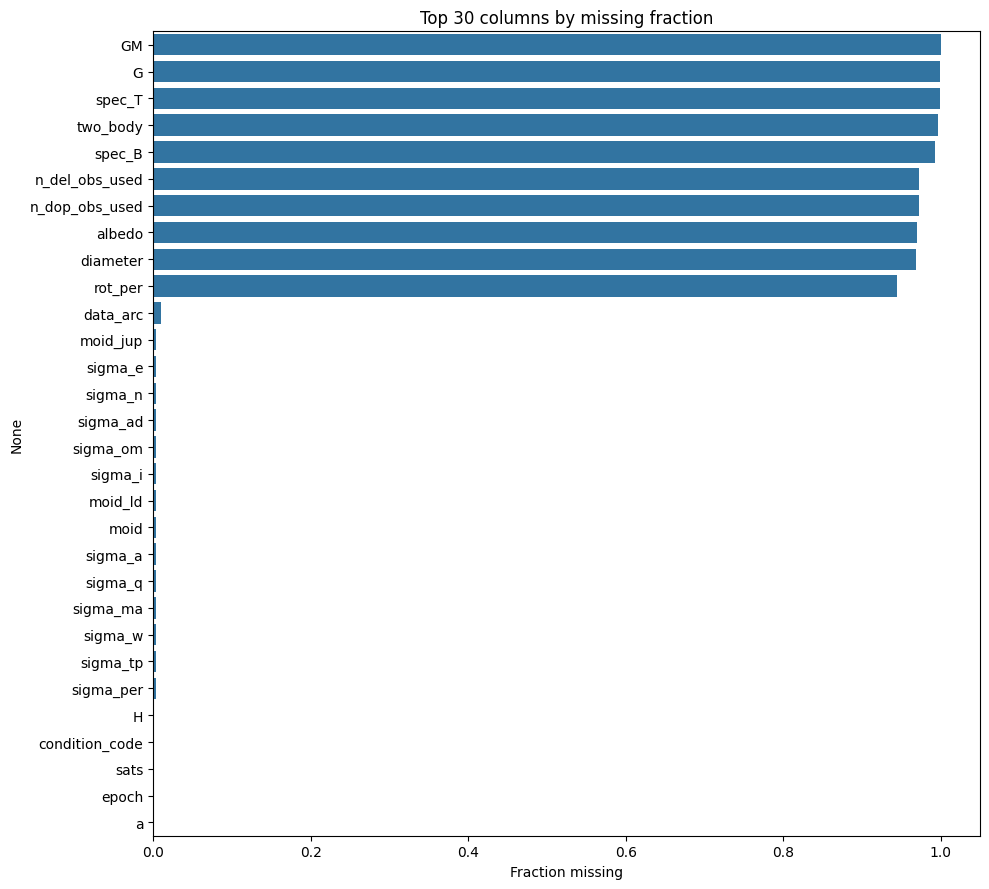

In [25]:
top = 30
top_missing = missing_summary.head(top)
fig, ax = plt.subplots(figsize=(10, min(0.3*top, 10)))
sns.barplot(x="missing_pct", y=top_missing.index, data=top_missing, ax=ax)
ax.set_xlabel("Fraction missing")
ax.set_title(f"Top {top} columns by missing fraction")
plt.tight_layout()
plt.show()


In [26]:
# threshold to drop columns with excessive missingness
DROP_THRESHOLD = 0.70

# columns that should be kept even if missing a lot (scientifically important)
KEEP_ALWAYS = ['albedo', 'diameter', 'rot_per']

cols_to_drop = (
    missing_summary[
        (missing_summary["missing_pct"] > DROP_THRESHOLD)
        & (~missing_summary.index.isin(KEEP_ALWAYS))
    ].index.tolist()
)

cols_to_keep = [c for c in df.columns if c not in cols_to_drop]

print("Columns to drop (>{:.0%} missing and not critical):".format(DROP_THRESHOLD), len(cols_to_drop))
for c in cols_to_drop:
    print("  ", c)

print("\nColumns kept despite high missingness:", [c for c in KEEP_ALWAYS if c in df.columns])
print("\nReduced dataframe shape (after correction):")
df_reduced = df[cols_to_keep].copy()
df_reduced.shape
# Save the reduced dataset with important columns retained
CLEANED_MISSING_PATH = "../Dataset/neo_missing_handled.csv"
df_reduced.to_csv(CLEANED_MISSING_PATH, index=False)

print(f"\n✅ Cleaned dataset saved as {CLEANED_MISSING_PATH}")
print(f"Final shape: {df_reduced.shape}")


Columns to drop (>70% missing and not critical): 7
   GM
   G
   spec_T
   two_body
   spec_B
   n_del_obs_used
   n_dop_obs_used

Columns kept despite high missingness: ['albedo', 'diameter', 'rot_per']

Reduced dataframe shape (after correction):

✅ Cleaned dataset saved as ../Dataset/neo_missing_handled.csv
Final shape: (39709, 38)


In [33]:
# Load your reduced dataset
DATA_PATH = "../Dataset/neo_missing_handled.csv"  # replace with your actual cleaned CSV
df = pd.read_csv(DATA_PATH)
# Rows where diameter is missing
missing_diameter = df['diameter'].isna()
print("Rows with missing diameter:", missing_diameter.sum())

# Rows where diameter is missing but H is present (can estimate)
can_estimate = missing_diameter & df['H'].notna()
print("Rows where diameter can be estimated using H + albedo:", can_estimate.sum())

# Rows where diameter is missing and H is also missing (cannot estimate)
cannot_estimate = missing_diameter & df['H'].isna()
print("Rows where diameter cannot be estimated (H missing):", cannot_estimate.sum())


Rows with missing diameter: 38461
Rows where diameter can be estimated using H + albedo: 38461
Rows where diameter cannot be estimated (H missing): 0


In [34]:
def compute_diameter_km(H, albedo):
    # Standard asteroid diameter formula: D(km) = 1329 / sqrt(albedo) * 10^(-H/5)
    return 1329.0 / np.sqrt(albedo) * (10 ** (-H / 5.0))

# Compute median albedo fallback (use available values)
median_albedo = df_reduced['albedo'].dropna().median()
if pd.isna(median_albedo):
    median_albedo = 0.14  # sensible default if absolutely no albedo values
print("Median albedo used for fallback:", median_albedo)

# Create flag column for estimated diameter
df_reduced['diameter_estimated_flag'] = 0

# Step 1: Estimate diameter where original diameter is missing and H is available
diam_mask = df_reduced['diameter'].isna() & df_reduced['H'].notna()
albedos_for_est = df_reduced.loc[diam_mask, 'albedo'].fillna(median_albedo)
df_reduced.loc[diam_mask, 'diameter'] = compute_diameter_km(df_reduced.loc[diam_mask, 'H'], albedos_for_est)
df_reduced.loc[diam_mask, 'diameter_estimated_flag'] = 1  # mark as estimated

# Step 2: Fill any remaining missing diameter with median of current diameters
remaining_missing = df_reduced['diameter'].isna()
df_reduced.loc[remaining_missing, 'diameter'] = df_reduced['diameter'].median()
df_reduced.loc[remaining_missing, 'diameter_estimated_flag'] = 1  # mark as estimated

# Summary
print("Total rows with estimated diameter:", df_reduced['diameter_estimated_flag'].sum())
print("Remaining missing diameters:", df_reduced['diameter'].isna().sum())


Median albedo used for fallback: 0.137
Total rows with estimated diameter: 38461
Remaining missing diameters: 0


In [35]:
# Key columns we care about for modeling
key_numeric = ['a','e','i','q','ad','per_y','H','diameter','albedo','moid','t_jup','data_arc','rms']
existing_keys = [c for c in key_numeric if c in df_reduced.columns]

# Add indicator columns showing original missingness (before imputation)
for c in existing_keys:
    df_reduced[f"{c}_was_missing"] = df_reduced[c].isna()

# Also mark where we estimated diameter
df_reduced['diameter_was_estimated'] = df_reduced['diameter_estimated_flag'] == 1


In [37]:
# Prepare lists for imputation
numeric_cols = df_reduced.select_dtypes(include=[np.number]).columns.tolist()
# remove boolean indicator columns from numeric imputation
numeric_cols = [c for c in numeric_cols if not c.endswith("_was_missing") and c != 'diameter_was_estimated']

categorical_cols = df_reduced.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipelines
numeric_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="constant", fill_value="missing")

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_imputer, numeric_cols),
    ("cat", categorical_imputer, categorical_cols)
], remainder='passthrough')

# Apply transformations
X = df_reduced.copy()
X_before = X.shape
X_transformed = preprocessor.fit_transform(X)

# Column names after transformation
num_out_cols = numeric_cols
cat_out_cols = categorical_cols
remainder_cols = [c for c in X.columns if c not in numeric_cols + categorical_cols]
out_cols = num_out_cols + cat_out_cols + remainder_cols

df_imputed = pd.DataFrame(X_transformed, columns=out_cols, index=X.index)

# Convert numeric columns back to numeric dtype
for c in numeric_cols:
    df_imputed[c] = pd.to_numeric(df_imputed[c], errors='coerce')

print("Before/After shapes:", X_before, df_imputed.shape)

df_imputed.to_csv("../Dataset/neo_imputed_step1.csv", index=False)



Before/After shapes: (39709, 53) (39709, 53)


In [18]:
# If original diameter missing but we estimated it, fill the imputed df's diameter with the estimate
if 'diameter' in df_imputed.columns and 'diameter_estimated' in df_imputed.columns:
    diam_missing_idx = df_imputed['diameter'].isna() & df_imputed['diameter_estimated'].notna()
    df_imputed.loc[diam_missing_idx, 'diameter'] = df_imputed.loc[diam_missing_idx, 'diameter_estimated']

# Save the imputed dataset and the reduced dataset (pre-imputation) for record
#df_reduced.to_csv("../Dataset/neo_reduced_preimpute.csv", index=False)
df_imputed.to_csv("../Dataset/neo_imputed_step1.csv", index=False)

#print("Saved: Dataset/neo_reduced_preimpute.csv (pre-impute)")
print("Saved: Dataset/neo_imputed_step1.csv (post-impute)")


C:\Users\mail2\AppData\Local\Temp\ipykernel_10020\1675458747.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_imputed.loc[diam_missing_idx, 'diameter'] = df_imputed.loc[diam_missing_idx, 'diameter_estimated']


Saved: Dataset/neo_imputed_step1.csv (post-impute)


In [38]:
import json
summary = {
    "total_rows": int(len(df)),
    "drop_threshold": float(DROP_THRESHOLD),
    "dropped_columns_count": len(cols_to_drop),
    "dropped_columns": cols_to_drop,
    "median_albedo_used": float(median_albedo),
    "estimated_diameter_count": int(df_reduced['diameter_was_estimated'].sum()),
}
with open("../Dataset/missingness_action_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved Dataset/missingness_action_summary.json")


Saved Dataset/missingness_action_summary.json


In [40]:
df_imputed.columns

Index(['sats', 'H', 'diameter', 'albedo', 'rot_per', 'epoch', 'e', 'a', 'q',
       'i', 'om', 'w', 'ma', 'ad', 'n', 'per', 'per_y', 'moid', 'moid_ld',
       'moid_jup', 't_jup', 'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i',
       'sigma_om', 'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp',
       'sigma_per', 'data_arc', 'n_obs_used', 'condition_code', 'rms',
       'diameter_estimated_flag', 'epoch_cal', 'class', 'a_was_missing',
       'e_was_missing', 'i_was_missing', 'q_was_missing', 'ad_was_missing',
       'per_y_was_missing', 'H_was_missing', 'diameter_was_missing',
       'albedo_was_missing', 'moid_was_missing', 't_jup_was_missing',
       'data_arc_was_missing', 'rms_was_missing', 'diameter_was_estimated'],
      dtype='object')

In [41]:
cols_to_drop = [c for c in df_imputed.columns if c.endswith("_was_missing") or c == "diameter_was_estimated"]
df_model = df_imputed.drop(columns=cols_to_drop)
print("Columns used for modeling:", df_model.columns.tolist())


Columns used for modeling: ['sats', 'H', 'diameter', 'albedo', 'rot_per', 'epoch', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'per', 'per_y', 'moid', 'moid_ld', 'moid_jup', 't_jup', 'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'data_arc', 'n_obs_used', 'condition_code', 'rms', 'diameter_estimated_flag', 'epoch_cal', 'class']


In [44]:
df_model.to_csv("../Dataset/neo_model.csv", index=False)
#Imputed includes indicator columns
#print("Saved: Dataset/neo_reduced_preimpute.csv (pre-impute)")
print("Saved: Dataset/neo_model.csv (post-impute)")

Saved: Dataset/neo_model.csv (post-impute)
